In [98]:
import numpy as np
import scipy
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,17.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
3,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,15.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
4,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,15.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P37136', 'xref_name': None, 'xre...",Rattus norvegicus,Acetylcholinesterase,15.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116
6,"[{'xref_id': 'O42275', 'xref_name': None, 'xre...",Electrophorus electricus,Acetylcholinesterase,15.0,False,CHEMBL4078,"[{'accession': 'O42275', 'component_descriptio...",SINGLE PROTEIN,8005
7,"[{'xref_id': 'P23795', 'xref_name': None, 'xre...",Bos taurus,Acetylcholinesterase,15.0,False,CHEMBL4768,"[{'accession': 'P23795', 'component_descriptio...",SINGLE PROTEIN,9913
8,[],Anopheles gambiae,Acetylcholinesterase,15.0,False,CHEMBL2046266,"[{'accession': 'Q869C3', 'component_descriptio...",SINGLE PROTEIN,7165
9,[],Bemisia tabaci,AChE2,15.0,False,CHEMBL2366409,"[{'accession': 'B3SST5', 'component_descriptio...",SINGLE PROTEIN,7038


In [3]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

In [4]:
# 7m10s
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,None,20703835,[],CHEMBL4627889,Inhibition of AChE (unknown origin) using acet...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,None,None,CHEMBL4627271,Bioorg Med Chem Lett,2020.0,"{'bei': '14.05', 'le': '0.27', 'lle': '1.62', ...",CHEMBL4645659,None,CHEMBL4645659,6.13,False,http://www.openphacts.org/units/Nanomolar,3486808,=,1,True,=,None,IC50,nM,None,740.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.74
7545,None,20703856,[],CHEMBL4627888,Inhibition of AChE (unknown origin),B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,None,None,CHEMBL4627271,Bioorg Med Chem Lett

In [5]:
df2 = df[df.standard_value.notna()]
df2 = df2[df2.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,None,20703835,[],CHEMBL4627889,Inhibition of AChE (unknown origin) using acet...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,None,None,CHEMBL4627271,Bioorg Med Chem Lett,2020.0,"{'bei': '14.05', 'le': '0.27', 'lle': '1.62', ...",CHEMBL4645659,None,CHEMBL4645659,6.13,False,http://www.openphacts.org/units/Nanomolar,3486808,=,1,True,=,None,IC50,nM,None,740.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.74
7545,None,20703856,[],CHEMBL4627888,Inhibition of AChE (unknown origin),B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,None,None,CHEMBL4627271,Bioorg Med Chem Lett

In [6]:
df2.canonical_smiles.nunique()

5103

In [7]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,None,20703806,[],CHEMBL4627871,Inhibition of human erythrocyte AChE using S-a...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,Outside typical range,Values for this activity type are unusually la...,CHEMBL4627270,Bioorg Med Chem,2020.0,None,CHEMBL4645476,None,CHEMBL4650931,None,False,http://www.openphacts.org/units/Nanomolar,3486794,=,1,True,=,None,IC50,nM,None,266000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,266.0
7544,None,20703835,[],CHEMBL4627889,Inhibition of AChE (unknown origin) using acet...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,None,None,CHEMB

In [8]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3.reset_index(inplace=True, drop=True)
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0
...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0


In [9]:
# label as active or inactive
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4.dropna(inplace=True) # added by me
df4

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0,inactive
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive


In [10]:
# PART 2

In [11]:
df = df4.copy(deep=True)
del df2, df3, df4, df2_nr

In [12]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [13]:
smiles = []
for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1).dropna()
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
5098,CHEMBL4645476,266000.0,inactive,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1
5099,CHEMBL4645659,740.0,active,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC
5100,CHEMBL513063,510.0,active,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1
5101,CHEMBL4640608,125000.0,inactive,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...


In [14]:
def lipinski(smiles):

    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData = np.arange(1,1)
    i = 0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1      
    
    columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [15]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
5098,306.406,2.7027,2.0,4.0
5099,436.489,4.5050,1.0,7.0
5100,331.441,3.2431,1.0,5.0
5101,447.506,5.1143,1.0,5.0


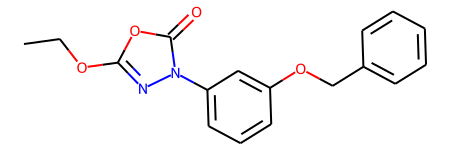

In [16]:
Chem.MolFromSmiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1')

In [17]:
df_combined = pd.concat([df, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0,inactive,306.406,2.7027,2.0,4.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active,436.489,4.5050,1.0,7.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active,331.441,3.2431,1.0,5.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive,447.506,5.1143,1.0,5.0


In [18]:
df_combined['standard_value'] = df_combined['standard_value'].astype(np.float64)

In [19]:
def norm_value(data):
    norm = []

    for i in data['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    data['standard_value_norm'] = norm
    x = data.drop(columns='standard_value')
        
    return x

In [20]:
def pIC50(data):
    pIC50 = []

    for i in data['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    data['pIC50'] = pIC50
    x = data.drop(columns='standard_value_norm')
        
    return x

In [21]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,inactive,306.406,2.7027,2.0,4.0,266000.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,740.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,510.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,125000.0


In [22]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


In [23]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


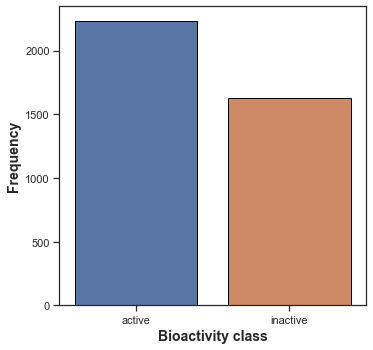

In [24]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.show()

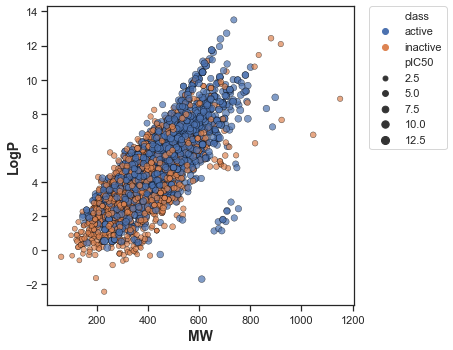

In [25]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

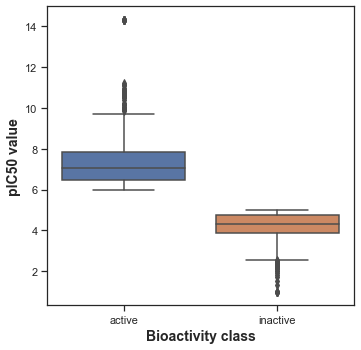

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.show()

In [31]:
def mannwhitney(descriptor):
  # from numpy.random import randn
  # from scipy.stats import mannwhitneyu

# seed the random number generator
  np.random.seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = scipy.stats.mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

In [32]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3637972.0,0.0,0.05,Different distribution (reject H0)


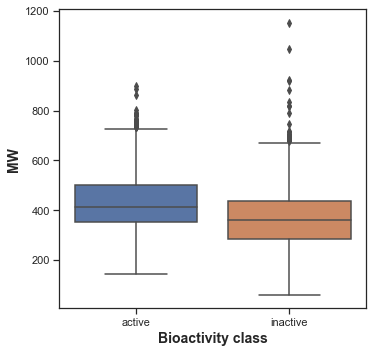

In [33]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
plt.show()

In [34]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2377439.0,7.525552e-60,0.05,Different distribution (reject H0)


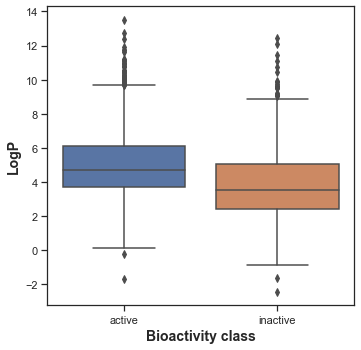

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.show()

In [36]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2427121.5,1.247187e-70,0.05,Different distribution (reject H0)


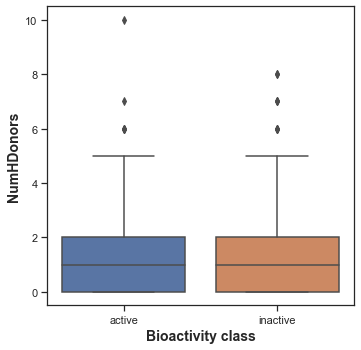

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.show()

In [38]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2068562.0,1.958353e-14,0.05,Different distribution (reject H0)


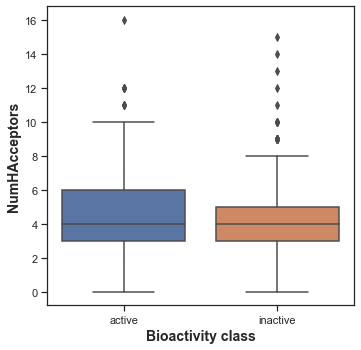

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.show()

In [40]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1935770.5,0.000523,0.05,Different distribution (reject H0)


In [41]:
# PART 3

In [47]:
df = df_final.copy(deep=True)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


In [49]:
selection = ['canonical_smiles','molecule_chembl_id']
df[selection].to_csv('molecule.smi', sep='\t', index=False, header=False)

In [14]:
! wget -O padel.sh  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! wget -O padel.zip https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2021-10-31 02:05:48--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2021-10-31 02:05:49--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
SSL_INIT
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh’

padel.sh            100%[===================>]     231  --.-KB/s    in 0s      

2021-10-31 02:05:49 (64.1 MB/s) - ‘padel.sh’ saved [23

In [13]:
! unzip -o padel.zip
! rm -rf padel.zip __MACOSX

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [52]:
# ! bash padel.sh

Processing CHEMBL133897 in molecule.smi (1/5103). 
Processing CHEMBL130628 in molecule.smi (4/5103). 
Processing CHEMBL336398 in molecule.smi (2/5103). 
Processing CHEMBL131588 in molecule.smi (3/5103). 
Processing CHEMBL130478 in molecule.smi (5/5103). 
Processing CHEMBL130112 in molecule.smi (6/5103). 
Processing CHEMBL130098 in molecule.smi (7/5103). 
Processing CHEMBL337486 in molecule.smi (8/5103). 
Processing CHEMBL336538 in molecule.smi (9/5103). 
Processing CHEMBL131051 in molecule.smi (10/5103). 
Processing CHEMBL341437 in molecule.smi (11/5103). 
Processing CHEMBL335033 in molecule.smi (12/5103). 
Processing CHEMBL339995 in molecule.smi (15/5103). Average speed: 0.65 s/mol.
Processing CHEMBL122983 in molecule.smi (13/5103). Average speed: 1.90 s/mol.
Processing CHEMBL338720 in molecule.smi (14/5103). Average speed: 1.91 s/mol.
Processing CHEMBL335158 in molecule.smi (16/5103). Average speed: 0.54 s/mol.
Processing CHEMBL131536 in molecule.smi (17/5103). Average speed: 0.46 s/

In [64]:
x = pd.read_csv('descriptors_output.csv')
x.drop(columns='Name', inplace=True)
x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,PubchemFP40,PubchemFP41,PubchemFP42,PubchemFP43,PubchemFP44,PubchemFP45,PubchemFP46,PubchemFP47,PubchemFP48,PubchemFP49,PubchemFP50,PubchemFP51,PubchemFP52,PubchemFP53,PubchemFP54,PubchemFP55,PubchemFP56,PubchemFP57,PubchemFP58,PubchemFP59,PubchemFP60,PubchemFP61,PubchemFP62,PubchemFP63,PubchemFP64,PubchemFP65,PubchemFP66,PubchemFP67,PubchemFP68,PubchemFP69,PubchemFP70,PubchemFP71,PubchemFP72,PubchemFP73,PubchemFP74,PubchemFP75,PubchemFP76,PubchemFP77,PubchemFP78,PubchemFP79,PubchemFP80,PubchemFP81,PubchemFP82,PubchemFP83,PubchemFP84,PubchemFP85,PubchemFP86,PubchemFP87,PubchemFP88,PubchemFP89,PubchemFP90,PubchemFP91,PubchemFP92,PubchemFP93,PubchemFP94,PubchemFP95,PubchemFP96,PubchemFP97,PubchemFP98,PubchemFP99,PubchemFP100,PubchemFP101,PubchemFP102,PubchemFP103,PubchemFP104,PubchemFP105,PubchemFP106,PubchemFP107,PubchemFP108,PubchemFP109,PubchemFP110,PubchemFP111,PubchemFP112,PubchemFP113,PubchemFP114,PubchemFP115,PubchemFP116,PubchemFP117,PubchemFP118,PubchemFP119,PubchemFP120,PubchemFP121,PubchemFP122,PubchemFP123,PubchemFP124,PubchemFP125,PubchemFP126,PubchemFP127,PubchemFP128,PubchemFP129,PubchemFP130,PubchemFP131,PubchemFP132,PubchemFP133,PubchemFP134,PubchemFP135,PubchemFP136,PubchemFP137,PubchemFP138,PubchemFP139,PubchemFP140,PubchemFP141,PubchemFP142,PubchemFP143,PubchemFP144,PubchemFP145,PubchemFP146,PubchemFP147,PubchemFP148,PubchemFP149,PubchemFP150,PubchemFP151,PubchemFP152,PubchemFP153,PubchemFP154,PubchemFP155,PubchemFP156,PubchemFP157,PubchemFP158,PubchemFP159,PubchemFP160,PubchemFP161,PubchemFP162,PubchemFP163,PubchemFP164,PubchemFP165,PubchemFP166,PubchemFP167,PubchemFP168,PubchemFP169,PubchemFP170,PubchemFP171,PubchemFP172,PubchemFP173,PubchemFP174,PubchemFP175,PubchemFP176,PubchemFP177,PubchemFP178,PubchemFP179,PubchemFP180,PubchemFP181,PubchemFP182,PubchemFP183,PubchemFP184,PubchemFP185,PubchemFP186,PubchemFP187,PubchemFP188,PubchemFP189,PubchemFP190,PubchemFP191,PubchemFP192,PubchemFP193,PubchemFP194,PubchemFP195,PubchemFP196,PubchemFP197,PubchemFP198,PubchemFP199,PubchemFP200,PubchemFP201,PubchemFP202,PubchemFP203,PubchemFP204,PubchemFP205,PubchemFP206,PubchemFP207,PubchemFP208,PubchemFP209,PubchemFP210,PubchemFP211,PubchemFP212,PubchemFP213,PubchemFP214,PubchemFP215,PubchemFP216,PubchemFP217,PubchemFP218,PubchemFP219,PubchemFP220,PubchemFP221,PubchemFP222,PubchemFP223,PubchemFP224,PubchemFP225,PubchemFP226,PubchemFP227,PubchemFP228,PubchemFP229,PubchemFP230,PubchemFP231,PubchemFP232,PubchemFP233,PubchemFP234,PubchemFP235,PubchemFP236,PubchemFP237,PubchemFP238,PubchemFP239,PubchemFP240,PubchemFP241,PubchemFP242,PubchemFP243,PubchemFP244,PubchemFP245,PubchemFP246,PubchemFP247,PubchemFP248,PubchemFP249,PubchemFP250,PubchemFP251,PubchemFP252,PubchemFP253,PubchemFP254,PubchemFP255,PubchemFP256,PubchemFP257,PubchemFP258,PubchemFP259,PubchemFP260,PubchemFP261,PubchemFP262,PubchemFP263,PubchemFP264,PubchemFP265,PubchemFP266,PubchemFP267,PubchemFP268,PubchemFP269,PubchemFP270,PubchemFP271,PubchemFP272,PubchemFP273,PubchemFP274,PubchemFP275,PubchemFP276,PubchemFP277,PubchemFP278,PubchemFP279,PubchemFP280,PubchemFP281,PubchemFP282,PubchemFP283,PubchemFP284,PubchemFP285,PubchemFP286,PubchemFP287,PubchemFP288,PubchemFP289,PubchemFP290,PubchemFP291,PubchemFP292,PubchemFP293,PubchemFP294,PubchemFP295,PubchemFP296,PubchemFP297,PubchemFP298,PubchemFP299,PubchemFP300,PubchemFP301,PubchemFP302,PubchemFP303,PubchemFP304,PubchemFP305,PubchemFP306,PubchemFP307,PubchemFP308,PubchemFP309,PubchemFP310,PubchemFP311,PubchemFP312,PubchemFP313,PubchemFP314,PubchemFP315,P

In [65]:
y = df['pIC50']
y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5098    3.575118
5099    6.130768
5100    6.292430
5101    3.903090
5102    4.000000
Name: pIC50, Length: 5103, dtype: float64

In [79]:
x = x.loc[:, x.var() != 0]
x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP28,PubchemFP30,PubchemFP31,PubchemFP33,PubchemFP34,PubchemFP37,PubchemFP38,PubchemFP39,PubchemFP43,PubchemFP44,PubchemFP46,PubchemFP47,PubchemFP66,PubchemFP115,PubchemFP116,PubchemFP118,PubchemFP129,PubchemFP130,PubchemFP131,PubchemFP132,PubchemFP143,PubchemFP144,PubchemFP145,PubchemFP146,PubchemFP147,PubchemFP148,PubchemFP149,PubchemFP150,PubchemFP151,PubchemFP152,PubchemFP153,PubchemFP154,PubchemFP155,PubchemFP156,PubchemFP157,PubchemFP159,PubchemFP160,PubchemFP164,PubchemFP166,PubchemFP167,PubchemFP171,PubchemFP173,PubchemFP174,PubchemFP178,PubchemFP179,PubchemFP180,PubchemFP181,PubchemFP182,PubchemFP183,PubchemFP184,PubchemFP185,PubchemFP186,PubchemFP187,PubchemFP188,PubchemFP189,PubchemFP190,PubchemFP191,PubchemFP192,PubchemFP193,PubchemFP194,PubchemFP195,PubchemFP197,PubchemFP198,PubchemFP199,PubchemFP200,PubchemFP201,PubchemFP202,PubchemFP206,PubchemFP207,PubchemFP209,PubchemFP213,PubchemFP214,PubchemFP215,PubchemFP216,PubchemFP217,PubchemFP218,PubchemFP219,PubchemFP220,PubchemFP221,PubchemFP222,PubchemFP223,PubchemFP227,PubchemFP228,PubchemFP229,PubchemFP230,PubchemFP241,PubchemFP243,PubchemFP244,PubchemFP248,PubchemFP250,PubchemFP251,PubchemFP255,PubchemFP256,PubchemFP257,PubchemFP258,PubchemFP259,PubchemFP260,PubchemFP261,PubchemFP262,PubchemFP283,PubchemFP284,PubchemFP285,PubchemFP286,PubchemFP287,PubchemFP291,PubchemFP292,PubchemFP293,PubchemFP294,PubchemFP296,PubchemFP297,PubchemFP298,PubchemFP299,PubchemFP300,PubchemFP301,PubchemFP304,PubchemFP305,PubchemFP308,PubchemFP314,PubchemFP316,PubchemFP327,PubchemFP328,PubchemFP329,PubchemFP330,PubchemFP331,PubchemFP332,PubchemFP333,PubchemFP334,PubchemFP335,PubchemFP336,PubchemFP337,PubchemFP338,PubchemFP339,PubchemFP340,PubchemFP341,PubchemFP342,PubchemFP343,PubchemFP344,PubchemFP345,PubchemFP346,PubchemFP347,PubchemFP348,PubchemFP349,PubchemFP350,PubchemFP351,PubchemFP352,PubchemFP353,PubchemFP354,PubchemFP355,PubchemFP356,PubchemFP357,PubchemFP358,PubchemFP359,PubchemFP360,PubchemFP361,PubchemFP362,PubchemFP363,PubchemFP364,PubchemFP365,PubchemFP366,PubchemFP367,PubchemFP368,PubchemFP369,PubchemFP370,PubchemFP371,PubchemFP372,PubchemFP373,PubchemFP374,PubchemFP375,PubchemFP376,PubchemFP377,PubchemFP378,PubchemFP379,PubchemFP380,PubchemFP381,PubchemFP382,PubchemFP383,PubchemFP384,PubchemFP385,PubchemFP386,PubchemFP387,PubchemFP388,PubchemFP389,PubchemFP390,PubchemFP391,PubchemFP392,PubchemFP393,PubchemFP394,PubchemFP395,PubchemFP396,PubchemFP397,PubchemFP398,PubchemFP399,PubchemFP400,PubchemFP401,PubchemFP403,PubchemFP404,PubchemFP405,PubchemFP406,PubchemFP407,PubchemFP409,PubchemFP410,PubchemFP411,PubchemFP412,PubchemFP413,PubchemFP414,PubchemFP415,PubchemFP416,PubchemFP417,PubchemFP418,PubchemFP419,PubchemFP420,PubchemFP421,PubchemFP422,PubchemFP423,PubchemFP425,PubchemFP427,PubchemFP428,PubchemFP429,PubchemFP430,PubchemFP431,PubchemFP432,PubchemFP434,PubchemFP435,PubchemFP436,PubchemFP437,PubchemFP438,PubchemFP439,PubchemFP440,PubchemFP441,PubchemFP442,PubchemFP443,PubchemFP445,PubchemFP446,PubchemFP447,PubchemFP448,PubchemFP449,PubchemFP450,PubchemFP451,PubchemFP452,PubchemFP453,PubchemFP454,PubchemFP455,PubchemFP456,PubchemFP457,PubchemFP458,PubchemFP459,PubchemFP460,PubchemFP461,PubchemFP462,PubchemFP464,PubchemFP465,PubchemFP466,PubchemFP467,PubchemFP470,PubchemFP471,PubchemFP472,PubchemFP473,PubchemFP474,PubchemFP475,PubchemFP476,PubchemFP477,PubchemFP478,PubchemFP479,PubchemFP480,PubchemFP481,PubchemFP482,PubchemFP483,PubchemFP484,PubchemFP485,PubchemFP486,PubchemFP487,PubchemFP488,PubchemFP489,PubchemFP490,PubchemFP491,PubchemFP492,PubchemFP493,PubchemFP494,PubchemFP495,PubchemFP496,PubchemFP497,PubchemFP498,PubchemFP499,PubchemFP500,PubchemFP501,PubchemFP502,PubchemFP503,PubchemFP504,PubchemFP505,PubchemF

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [82]:
x_train.shape, y_train.shape

((4082, 634), (4082,))

In [83]:
x_test.shape, y_test.shape

((1021, 634), (1021,))

In [105]:
models = {
    'LGBM' : LGBMRegressor(),
    'XGBR' : XGBRegressor(use_label_encoder=False, eval_metric='logloss'),
    'NN'   : MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=100_000),
    'Hist' : HistGradientBoostingRegressor(),
}

In [106]:
print(f'Name\tScore\tTime')
for name,model in models.items():
    t0 = perf_counter()
    model.fit(x_train, y_train)
    score = model.score(x_test,  y_test)
    t1 = perf_counter()
    print(f'{name}\t{score:.3f}\t{(t1-t0):.2f}s')

Name	Score	Time
LGBM	0.322	0.18s
XGBR	0.264	1.92s
NN	0.024	7.82s
Hist	0.322	3.01s


In [118]:
preds = models['Hist'].predict(x_test)

/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


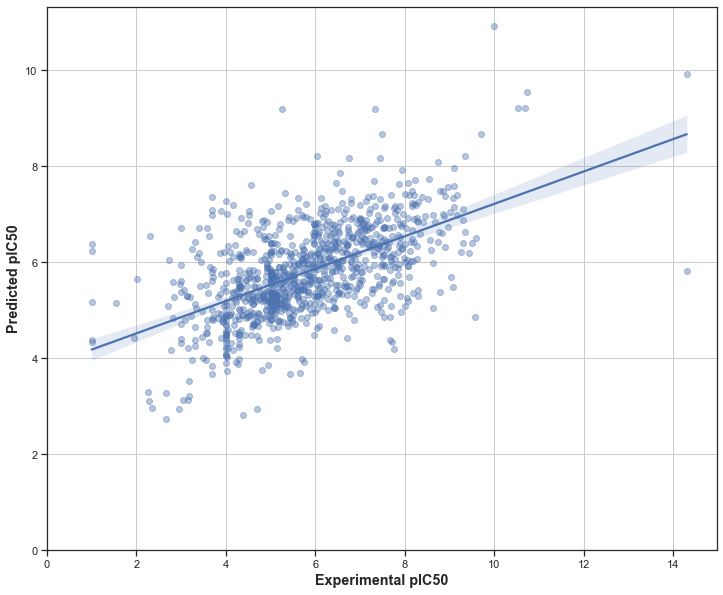

In [120]:
plt.figure(figsize=(12,10))
sns.regplot(y_test, preds, scatter_kws={'alpha':0.4})
plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
plt.xlim(0); plt.ylim(0); plt.grid(); plt.show()